In [25]:

import numpy as np
import torch
from pathlib import Path
from hydra.utils import to_absolute_path
#append the datasets starting with the word velocity froom  the folder "final_dataset_for_train"

In [26]:
field_name = "density"
num_channels = 1

#order of raw fields: density, velocity_x, velocity_y

base_folder = "Datasets/final_combined_dataset_for_train"
Re_list = [100, 200, 300, 400, 500]
data = torch.empty([0,num_channels,1024,256])

In [27]:
for Re in Re_list:
    data_file = f"{field_name}_Re_{Re}.pt"
    #join the path with the base folder
    data_file_path = Path(base_folder).joinpath(data_file)
    loaded_data = torch.load(data_file_path)
    loaded_data = loaded_data[350:]
    data = torch.cat([data, loaded_data], dim=0)

/tmp/ipykernel_2146052/3221829660.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(data_file_path)


In [28]:
new_density_array = np.zeros((data.shape[0], data.shape[1], data.shape[2]+2, data.shape[3]+2))

# Copy the original array into the middle of the new array
new_density_array[:, :, 1:-1, 1:-1] = data

# Copy the boundaries
# Top and bottom rows
new_density_array[:, :, 0, 1:-1] = data[:, :, 0, :]
new_density_array[:, :, -1, 1:-1] = data[:, :, -1, :]

# Left and right columns
new_density_array[:, :, 1:-1, 0] = data[:, :, :, 0]
new_density_array[:, :, 1:-1, -1] = data[:, :, :, -1]

# Corners
new_density_array[:, :, 0, 0] = data[:, :, 0, 0]        # Top-left
new_density_array[:, :, 0, -1] = data[:, :, 0, -1]      # Top-right
new_density_array[:, :, -1, 0] = data[:, :, -1, 0]      # Bottom-left
new_density_array[:, :, -1, -1] = data[:, :, -1, -1]    # Bottom-right

print(new_density_array.shape)  # Should print (100, 1, 1026, 258)


(3255, 1, 1026, 258)


In [29]:
np.savetxt("test.txt", new_density_array[0, 0, :, :] , delimiter=", ", fmt='%.3f')

In [30]:
#take the gradient of the density field using 
dx = 0.0001953125

grad_height = np.gradient(new_density_array, dx, axis=2) #across the rows (height)

# Gradient along the width (axis 3)
grad_width = np.gradient(new_density_array, dx, axis=3) #across the columns (width)

# Stack the gradients into a new array with shape [100, 2, 1026, 258]
# The first channel (index 1) will be the height gradient, the second (index 2) will be the width gradient
# We extract the first component from grad_height and grad_width since they return arrays of the same shape
spatial_gradients = np.concatenate((grad_height, grad_width), axis=1)
print(spatial_gradients.shape)  # Should print (100, 2, 1026, 258)

#discard the boundaries from the spatial gradient
spatial_gradients = spatial_gradients[:, :, 1:-1, 1:-1]
print(spatial_gradients.shape)  

(3255, 2, 1026, 258)
(3255, 2, 1024, 256)


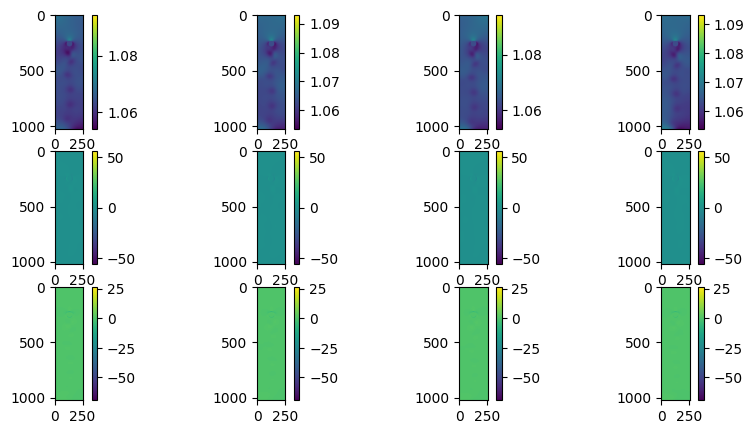

In [31]:
#plot the first 4 images
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 4, figsize=(10, 5))
for idx, i in enumerate(range(350, 354)):
    im = axs[0, idx].imshow(data[i, 0, :, :].cpu().detach().numpy(), cmap='viridis')
    im2 = axs[1, idx].imshow(spatial_gradients[i, 1, :, :] / data[i, 0, :, :].cpu().detach().numpy(), cmap='viridis')
    im3 = axs[2, idx].imshow(spatial_gradients[i, 0, :, :] / data[i, 0, :, :].cpu().detach().numpy(), cmap='viridis')
    
    # axs[i].axis('off')
    fig.colorbar(im, ax=axs[0, idx])
    fig.colorbar(im2, ax=axs[1, idx])
    fig.colorbar(im3, ax=axs[2, idx])
plt.show()

In [32]:
feature_y = (spatial_gradients[:, 1:2, :, :] / (3*data[:, 0:1, :, :].cpu().detach().numpy())) # spatial gradient along the width
feature_x = (spatial_gradients[:, 0:1, :, :] / (3*data[:, 0:1, :, :].cpu().detach().numpy())) # spatial gradient along the height
print(feature_y.shape)
print(feature_x.shape)

(3255, 1, 1024, 256)
(3255, 1, 1024, 256)


In [33]:
grad_feature = np.concatenate((feature_x, feature_y), axis=1)
print(grad_feature.shape)

(3255, 2, 1024, 256)


In [34]:
np.savetxt("grad_feature_x.txt", spatial_gradients[0, 0, :, :] , delimiter=",", fmt='%.2d')
np.savetxt("grad_feature_y.txt", spatial_gradients[0, 1, :, :], delimiter=",", fmt='%.2d')

In [35]:
mean_of_density_grad = np.mean(grad_feature, axis = (0,2,3))
std_of_density_grad= np.std(grad_feature, axis = (0,2,3))

print(mean_of_density_grad)
print(std_of_density_grad)

[-9.42896657e-03 -3.93026297e-05]
[0.21339866 0.2226781 ]


# Stats for grad_rho/3*rho 

In [36]:
"""
For Re from 200 to 400, the mean and std of the grad_density/3*density  for grid resolution 1024x256:

mean: [-9.14984033e-03 -4.81915969e-05]  (across the rows (height-->1024 rows) , across the columns (width-->256 cols))
std: [0.21336798 0.22451377]

"""

"""
For Re from 100 to 500, the mean and std of the grad_density/3*density  for grid resolution 1024x256:

mean: [-9.42896657e-03 -3.93026297e-05]
std: [0.21339866 0.2226781 ]

"""

'\nFor Re from 100 to 500, the mean and std of the grad_density/3*density  for grid resolution 1024x256:\n\nmean:\nstd: \n\n'